In [22]:
from datetime import datetime
from azure.ai.ml.entities import Data
from azure.ai.ml import automl, Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import MLClient
from azure.ai.ml.entities import ComputeInstance, AmlCompute
from azure.identity import DefaultAzureCredential
import os
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import json


credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "72fd2469-5a12-448a-b44f-3776240c011c"
    resource_group = "hycelAppLabeling"
    workspace = "findMyPetApp"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)



Found the config file in: /config.json


Deklaracaja folderu zawierającego dataset

In [42]:
my_data = Data(
    path="./myData/imgs",
    type=AssetTypes.URI_FOLDER,
    description="animals-images-labels",
    name="animals-labels",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Uploading imgs (16.37 MBs): 100%|██████████| 16374500/16374500 [00:03<00:00, 4156376.38it/s]




Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'animals-labels', 'description': 'animals-images-labels', 'tags': {}, 'properties': {}, 'id': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourceGroups/hycelapplabeling/providers/Microsoft.MachineLearningServices/workspaces/findmypetapp/data/animals-labels/versions/1', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/zalesinskanatasza1/code/Users/zalesinskanatasza', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7efcdb35ad70>, 'serialize': <msrest.serialization.Serializer object at 0x7efcdb35bbb0>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourcegroups/hycelapplabeling/workspaces/findmypetapp/datastores/workspaceblobstore/paths/LocalUpload/5049e2a06749ab3e6f70c3927b

Stworzenie pliku JSONL i konwersja do MLTable

In [43]:

src_images = "./myData/imgs"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./myData/training-mltable-folder/"



# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")


# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    for className in os.listdir(src_images):
        subDir = src_images + '/' + className
        print(subDir)
        if not os.path.isdir(subDir):
            continue
        # Scan each sub directary
        print("Parsing " + subDir)
        for image in os.listdir(subDir):
            json_line = dict(json_line_sample)
            json_line["image_url"] += f"{className}/{image}"
            json_line["label"] = className
            # train annotation
            train_f.write(json.dumps(json_line) + "\n")
            index += 1                

./myData/imgs/cat
Parsing ./myData/imgs/cat
./myData/imgs/dog
Parsing ./myData/imgs/dog
./myData/imgs/racoon
Parsing ./myData/imgs/racoon


Załadowanie MLTable

In [44]:
from azure.ai.ml.automl import SearchSpace, ClassificationPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Choice,
    Uniform,
    BanditPolicy,
)
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path="./myData/training-mltable-folder/")

Deklaracja joba

In [45]:
compute_name = "animalCompute"
exp_name = "animal-classification-experiment"

image_classification_job = automl.image_classification(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    target_column_name="label",
    primary_metric=ClassificationPrimaryMetrics.ACCURACY

)

Konfiguracja przeszukiwania przestrzeni parametrów

In [46]:
image_classification_job.set_limits(
    timeout_minutes=120,
    max_trials=10,
    max_concurrent_trials=1,
)

image_classification_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["vitb16r224", "vits16r224"]),
            learning_rate=Uniform(0.001, 0.01),
            number_of_epochs=Choice([15, 30]),
        ),
        SearchSpace(
            model_name=Choice(["seresnext", "resnet50"]),
            learning_rate=Uniform(0.001, 0.01),
            layers_to_freeze=Choice([0, 2]),
        ),
    ]
)

image_classification_job.set_sweep(
    sampling_algorithm="Random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

Przekazanie do wykonania

In [47]:
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"Created job: {returned_job}")
ml_client.jobs.stream(returned_job.name)

Uploading training-mltable-folder (0.16 MBs): 100%|██████████| 156493/156493 [00:00<00:00, 3228195.05it/s]




Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/21b5fc6359a4e4f19894a71ea021ce6a/training-mltable-folder'}, 'validation_data': None, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'bright_tangelo_vwlpbht05l', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourceGroups/hycelapplabeling/providers/Microsoft.MachineLearningServices/workspaces/findmypetapp/jobs/bright_tangelo_vwlpbht05l', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/zalesinskanatasza1/code/Users/zalesinskanatasza', 'creation_context': <azur

Znalezienie najlepszego modelu

In [48]:
import mlflow
from mlflow.tracking.client import MlflowClient

MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow_client = MlflowClient()
job_name = 'bright_tangelo_vwlpbht05l'


# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  bright_tangelo_vwlpbht05l_HD_3
Best child run: 
<Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 1.0,
 'AUC_weighted': 1.0,
 'accuracy': 1.0,
 'accuracy_train': 0.97872,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 1.0,
 'average_precision_score_weighted': 1.0,
 'f1_score_macro': 1.0,
 'f1_score_micro': 1.0,
 'f1_score_weighted': 1.0,
 'log_loss': 0.00806,
 'log_loss_train': 0.06255,
 'precision_score_macro': 1.0,
 'precision_score_micro': 1.0,
 'precision_score_weighted': 1.0,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'hyperparameters': '{"model": {"learning_rate": 0.009836530938179044, '
                    '"model_name": "vits16r224", "number_of_epochs": 15}}',
 'mlflow.parentRunId': 'bright_tangelo_vwlpbht05l_HD',
 'mlflow.rootRunId': 'bright_tangelo_vwlpbht05l',
 'mlflow.runName': 'placid_pump_wf332h0v',
 'mlflow.source.name': 'hd_image_classification_d

Rejestracja najlepszego modelu

In [49]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

model_name = "best-animal-labeling-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="Best animal labeling model",
    type=AssetTypes.MLFLOW_MODEL,
)


registered_model = ml_client.models.create_or_update(model)

Stworzenie endpointa

In [27]:
import datetime
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

online_endpoint_name = "animal-endpoint-test"

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Test endpoint for web app",
    auth_mode="key",
    tags={"foo": "bar"},
)



In [28]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://animal-endpoint-test.westeurope.inference.ml.azure.com/score', 'openapi_uri': 'https://animal-endpoint-test.westeurope.inference.ml.azure.com/swagger.json', 'name': 'animal-endpoint-test', 'description': 'Test endpoint for web app', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourcegroups/hycelapplabeling/providers/microsoft.machinelearningservices/workspaces/findmypetapp/onlineendpoints/animal-endpoint-test', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oe:84a452ed-f2be-46b9-8232-a2ab61a7a430:0cd86dd8-b7ce-42e9-a91d-a0616a4916eb?api-version=2022-02-01-preview'}, 'id': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourceGroups/hycelapplabel

In [29]:
registered_model = ml_client.models.get(name="best-animal-labeling-model", version="1")

deployment = ManagedOnlineDeployment(
    name="brain-mri-image-final",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_E2s_v3",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [30]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

Check: endpoint animal-endpoint-test exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ManagedOnlineDeployment({'private_network_connection': False, 'data_collector': None, 'provisioning_state': 'Succeeded', 'endpoint_name': 'animal-endpoint-test', 'type': 'Managed', 'name': 'brain-mri-image-final', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/od:84a452ed-f2be-46b9-8232-a2ab61a7a430:95986911-dd41-43bf-ac2d-13ce746bf392?api-version=2022-02-01-preview'}, 'id': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourceGroups/hycelapplabeling/providers/Microsoft.MachineLearningServices/workspaces/findmypetapp/onlineEndpoints/animal-endpoint-test/deployments/brain-mri-image-final', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/zalesinskanatasza1/code/Users/zalesinskanatasza', 'creation_context': None, 'serialize': <msrest.serialization

In [31]:
endpoint.traffic = {"brain-mri-image-final": 100}
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://animal-endpoint-test.westeurope.inference.ml.azure.com/score', 'openapi_uri': 'https://animal-endpoint-test.westeurope.inference.ml.azure.com/swagger.json', 'name': 'animal-endpoint-test', 'description': 'Test endpoint for web app', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourcegroups/hycelapplabeling/providers/microsoft.machinelearningservices/workspaces/findmypetapp/onlineendpoints/animal-endpoint-test', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oe:84a452ed-f2be-46b9-8232-a2ab61a7a430:d9eace9a-7be9-4c1e-9fc4-bb76fd3d0728?api-version=2022-02-01-preview'}, 'id': '/subscriptions/72fd2469-5a12-448a-b44f-3776240c011c/resourceGroups/hycelapplabel

In [14]:
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'brain-mri-image-final': 100}
https://animal-endpoint-test01041429.westeurope.inference.ml.azure.com/score


In [41]:
import base64

sample_image = "./myData/testData/racoon.jpg"


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [42]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [43]:


resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)



racoon (1.0)
[{'filename': '/tmp/tmp5vd1c2rk/tmpqum9ljcw', 'probs': [8.338411703334714e-07, 1.0692273235690664e-06, 0.9999980926513672], 'labels': ['cat', 'dog', 'racoon'], 'visualizations': None, 'attributions': None}]
{'filename': '/tmp/tmp5vd1c2rk/tmpqum9ljcw', 'probs': [8.338411703334714e-07, 1.0692273235690664e-06, 0.9999980926513672], 'labels': ['cat', 'dog', 'racoon'], 'visualizations': None, 'attributions': None}


<Figure size 1296x864 with 0 Axes>

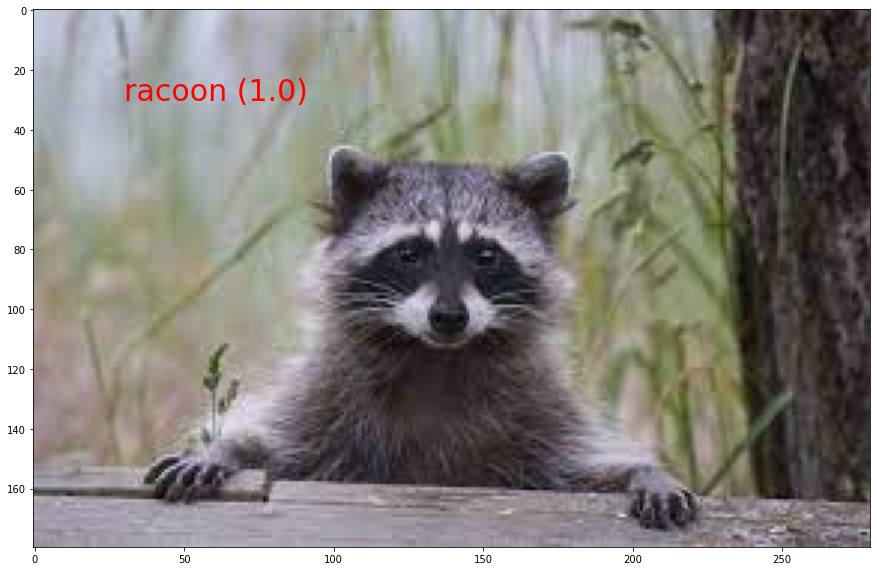

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp)[0]
label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)
print(json.loads(resp))
print(json.loads(resp)[0])

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

In [ ]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)